In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import geopandas as gpd 
import requests
import json
import contextily as cx
import textwrap


In [3]:

top_stations = pd.read_csv('sample.csv', usecols=['start_station_name', 'start_lat', 'start_lng', 'member_casual'])
top_stations.rename(columns={'start_station_name': 'name', 'start_lat': 'lat', 'start_lng': 'lon'}, inplace=True)
top_stations.head(10)


,name,lat,lon,member_casual
0,Bernard St & Elston Ave,41.949902,-87.713915,casual
1,McClurg Ct & Erie St,41.894352,-87.617831,member
2,Larrabee St & Division St,41.903486,-87.643353,member
3,Michigan Ave & Washington St,41.883693,-87.623919,casual
4,Loomis St & Jackson Blvd,41.877945,-87.662007,member
5,Honore St & Division St,41.903119,-87.673935,member
6,Larrabee St & North Ave,41.910210,-87.643500,member
7,Leavitt St & Chicago Ave,41.895497,-87.681910,casual
8,Wells St & Walton St,41.899930,-87.634430,member
9,Streeter Dr & Grand Ave,41.892278,-87.612043,member


In [5]:
top_stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   name           1000000 non-null  object 
 1   lat            1000000 non-null  float64
 2   lon            1000000 non-null  float64
 3   member_casual  1000000 non-null  object 
dtypes: float64(2), object(2)
memory usage: 30.5+ MB


In [6]:
top_stations = top_stations.sample(100000)
top_stations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 1790213 to 1353382
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   name           100000 non-null  object 
 1   lat            100000 non-null  float64
 2   lon            100000 non-null  float64
 3   member_casual  100000 non-null  object 
dtypes: float64(2), object(2)
memory usage: 3.8+ MB


In [6]:
# group by station and check for unique coordinates
groupy = top_stations.groupby('name')[['lat', 'lon']].nunique()
groupy.sort_values(by='lat', ascending=False).head(10)


,lat,lon
name,,
Clinton St & Madison St,2268,2278
Clinton St & Washington Blvd,2192,2208
Clark St & Elm St,2079,1984
Wells St & Concord Ln,2069,2164
Wells St & Elm St,2061,1986
Streeter Dr & Grand Ave,2016,2863
St. Clair St & Erie St,1857,1860
Canal St & Adams St,1786,1848
Wabash Ave & Grand Ave,1786,1823


In [7]:
# find top 10 stations by count
top_group = top_stations.groupby('name')['name'].agg(Count='count').sort_values(by='Count', ascending=False).head(10).reset_index()
top_group

,name,Count
0,Streeter Dr & Grand Ave,15756
1,DuSable Lake Shore Dr & Monroe St,8652
2,Michigan Ave & Oak St,8333
3,DuSable Lake Shore Dr & North Blvd,8281
4,Wells St & Concord Ln,7796
5,Clark St & Elm St,7363
6,Millennium Park,7336
7,Kingsbury St & Kinzie St,7295
8,Theater on the Lake,6966
9,Wells St & Elm St,6578


In [8]:

# Obtain station data from Divvy API
def jprint(obj):
    text = json.dumps(obj, sort_keys=True, indent=4)
    print(text)
bike = requests.get('https://gbfs.divvybikes.com/gbfs/en/station_information.json')
bike_json = bike.json()
bike_data = bike_json['data']['stations']
station = pd.DataFrame(bike_data)

# create dataframe with station name and coordinates
stations = station[['name', 'lat', 'lon']]
stations.head(10)

,name,lat,lon
0,Pulaski Rd & Lake St,41.885409,-87.726491
1,Paulina Ave & North Ave,41.909855,-87.669930
2,Hoyne Ave & 47th St,41.808227,-87.677180
3,Hale Ave & 107th St,41.699206,-87.668919
4,State St & Pershing Rd,41.823015,-87.626568
5,Avenue O & 134th St,41.651799,-87.540696
6,Glenwood Ave & Touhy Ave,42.012701,-87.666058
7,Kilbourn Ave & Milwaukee Ave,41.947071,-87.740008
8,Honore St & Division St,41.903119,-87.673935
9,63rd St Beach,41.780911,-87.576324


In [9]:
# join top 10 stations dataframe with coordinate data from API
top_station = top_group.merge(stations, on='name', how='left')
top_station.head(10)

,name,Count,lat,lon
0,Streeter Dr & Grand Ave,15756,41.892278,-87.612043
1,DuSable Lake Shore Dr & Monroe St,8652,41.880958,-87.616743
2,Michigan Ave & Oak St,8333,41.900960,-87.623777
3,DuSable Lake Shore Dr & North Blvd,8281,41.911722,-87.626804
4,Wells St & Concord Ln,7796,41.912133,-87.634656
5,Clark St & Elm St,7363,41.902973,-87.631280
6,Millennium Park,7336,41.881032,-87.624084
7,Kingsbury St & Kinzie St,7295,41.889177,-87.638506
8,Theater on the Lake,6966,41.926277,-87.630834
9,Wells St & Elm St,6578,41.903222,-87.634324


In [10]:
# create geodataframe from new top station dataframe
gdf = gpd.GeoDataFrame(top_station, geometry=gpd.points_from_xy(top_station.lon, top_station.lat), crs="EPSG:4326")
gdf.head(5)


,name,Count,lat,lon,geometry
0,Streeter Dr & Grand Ave,15756,41.892278,-87.612043,POINT (-87.61204 41.89228)
1,DuSable Lake Shore Dr & Monroe St,8652,41.880958,-87.616743,POINT (-87.61674 41.88096)
2,Michigan Ave & Oak St,8333,41.900960,-87.623777,POINT (-87.62378 41.90096)
3,DuSable Lake Shore Dr & North Blvd,8281,41.911722,-87.626804,POINT (-87.62680 41.91172)
4,Wells St & Concord Ln,7796,41.912133,-87.634656,POINT (-87.63466 41.91213)


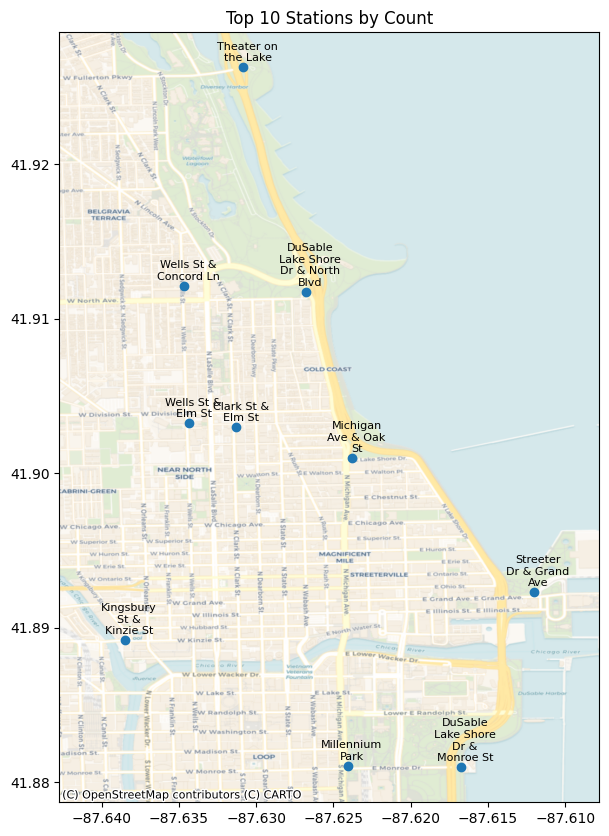

In [11]:
# plot top 10 stations on map
ax = gdf.plot(figsize=(10, 10))
cx.add_basemap(ax, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.Voyager)


for i, r in gdf.iterrows():
    wrapped_text = textwrap.fill(r['name'], width=10)
    ax.annotate(wrapped_text, xy=(r.geometry.x, r.geometry.y), xytext=(3, 3), textcoords="offset points", fontsize=8, ha='center', va='bottom')

buffer_ratio = 0.1
x_range = ax.get_xlim()[1] - ax.get_xlim()[0]
ax.set_xlim(ax.get_xlim()[0] - buffer_ratio * x_range, ax.get_xlim()[1] + buffer_ratio * x_range)
plt.title('Top 10 Stations by Count')
plt.show()

In [13]:
top_stations

,name,lat,lon,member_casual
1790213,Michigan Ave & Lake St,41.885431,-87.624683,casual
2532955,Halsted St & Wrightwood Ave,41.929152,-87.649112,casual
2757721,Clinton St & Roosevelt Rd,41.867118,-87.641088,member
1429576,Lincoln Ave & Diversey Pkwy,41.932225,-87.658617,member
4001820,Clifton Ave & Armitage Ave,41.918216,-87.656936,casual
...,...,...,...,...
1861866,Sheffield Ave & Webster Ave,41.921540,-87.653818,casual
1311245,Hermitage Ave & Polk St,41.871514,-87.669886,member
3200667,University Ave & 57th St,41.791458,-87.599871,member
3604440,Sedgwick St & Webster Ave,41.922167,-87.638888,member


In [12]:
# top 10 stations
x = top_stations.groupby('name').size().sort_values(ascending=False).head(10)
x

name
Streeter Dr & Grand Ave               15756
DuSable Lake Shore Dr & Monroe St      8652
Michigan Ave & Oak St                  8333
DuSable Lake Shore Dr & North Blvd     8281
Wells St & Concord Ln                  7796
Clark St & Elm St                      7363
Millennium Park                        7336
Kingsbury St & Kinzie St               7295
Theater on the Lake                    6966
Wells St & Elm St                      6578
dtype: int64

In [13]:
ab = []
for l in x.index:
    ab.append(l)
    
print(ab)

['Streeter Dr & Grand Ave', 'DuSable Lake Shore Dr & Monroe St', 'Michigan Ave & Oak St', 'DuSable Lake Shore Dr & North Blvd', 'Wells St & Concord Ln', 'Clark St & Elm St', 'Millennium Park', 'Kingsbury St & Kinzie St', 'Theater on the Lake', 'Wells St & Elm St']


In [15]:
# filter out non top 10 stations
plot_data = top_stations[top_stations['name'].isin(ab)]

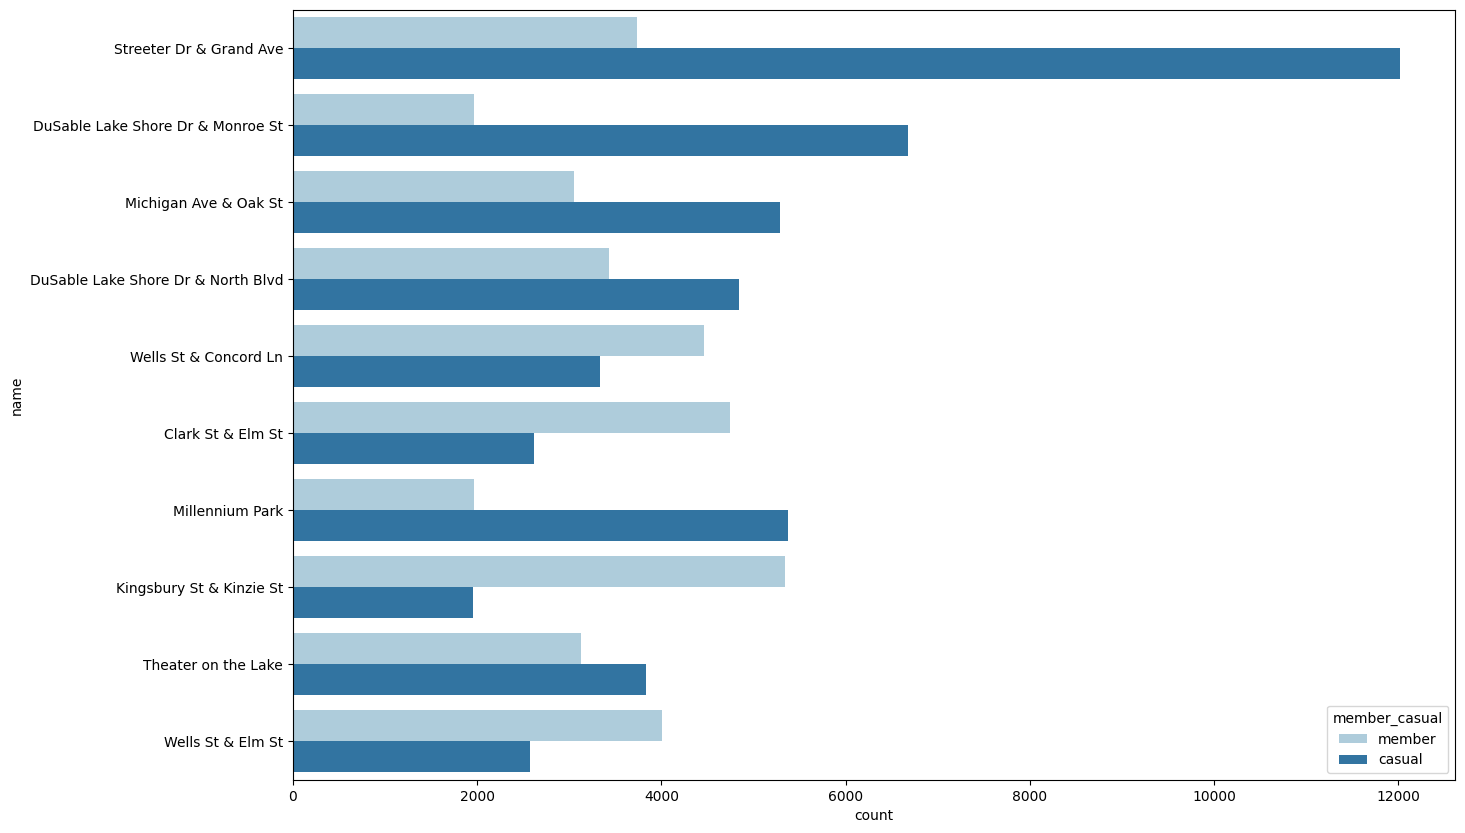

In [16]:

plt.figure(figsize=(15, 10))
sns.countplot(data=plot_data, y='name', hue='member_casual', order=ab, palette='Paired')
plt.show()

In [ ]:
sns.barplot(data=top_stations, x)

In [ ]:
for i, r in gdf.iterrows():
    ax.annotate(r['name'], xy=(r.geometry.x, r.geometry.y))

In [ ]:
ax2.table(cellText=df[['Station Name', 'Count']].values, colLabels=['Station Name', 'Count'], loc='center')


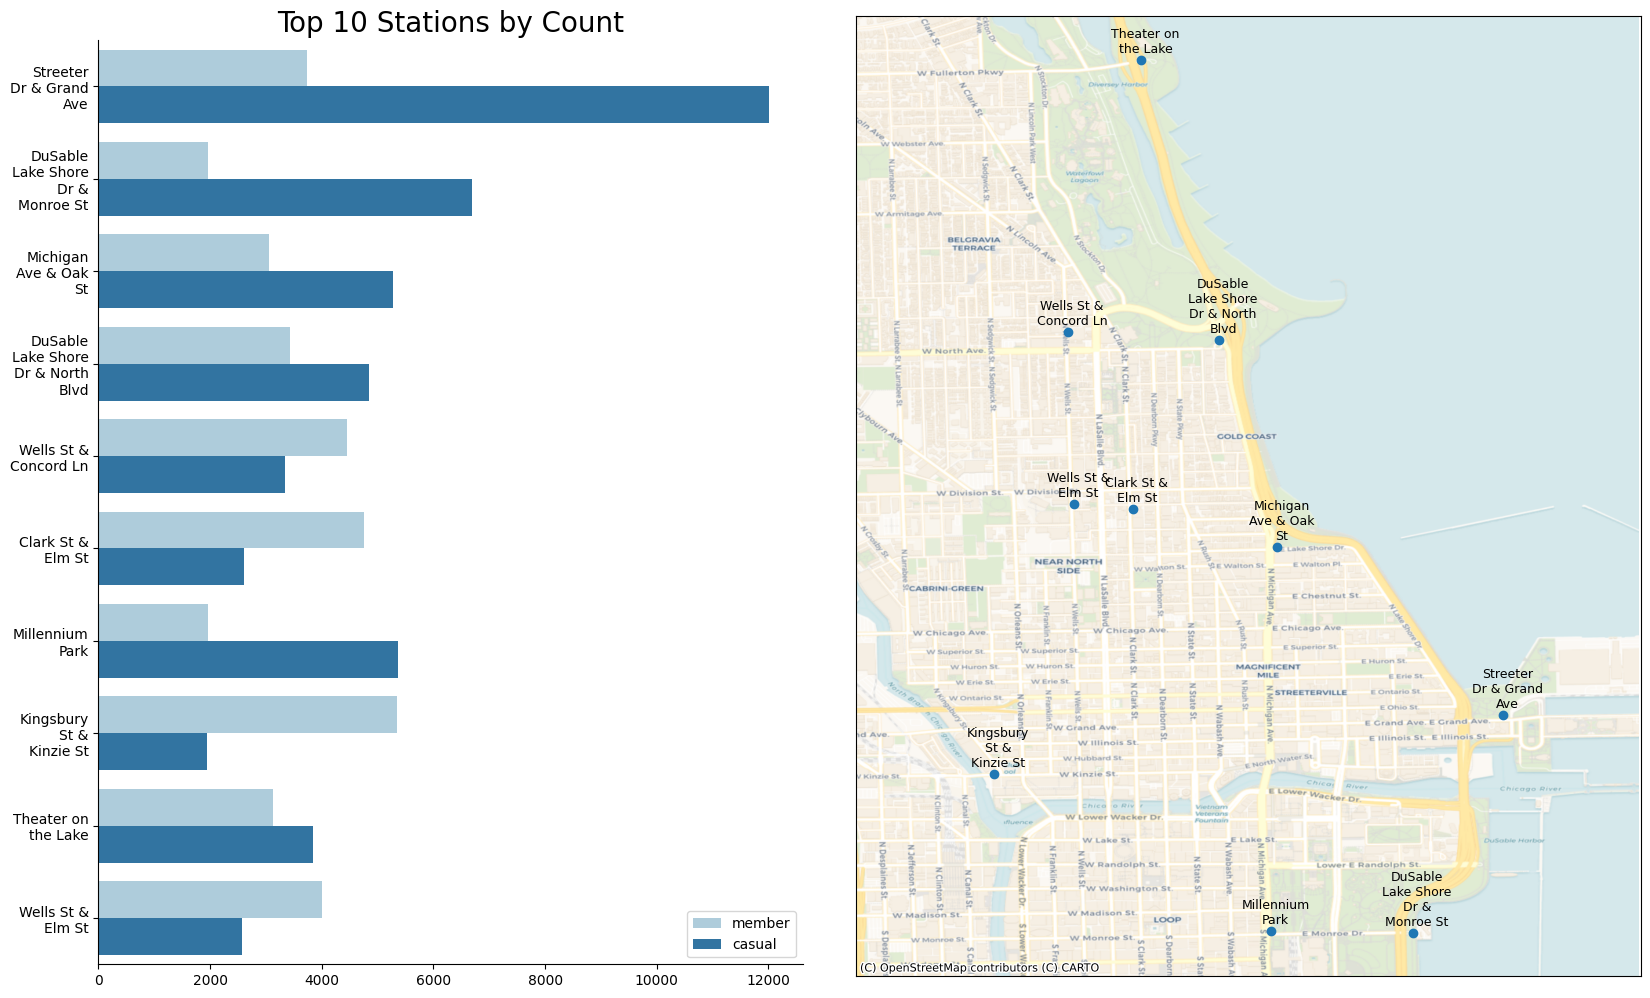

In [57]:

fig, axes = plt.subplots(1, 2, figsize=(20,12))

# BARPLOT
sns.countplot(ax=axes[0], data=plot_data, y='name', hue='member_casual', order=ab, palette='Paired').legend(title=[])
# wrap y tick labels
y_labels = axes[0].get_yticklabels()
wrapped_labels = [textwrap.fill(label.get_text(), width=10) for label in y_labels]

# adjust plot design
axes[0].set_yticklabels(wrapped_labels)
axes[0].set_title('Top 10 Stations by Count', fontsize=20)
axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# GEOPLOT
axes[1].set_position([0.5, 0.1, 0.4, 0.8])  # [left, bottom, width, height]

ax1 = gdf.plot(ax=axes[1])
cx.add_basemap(ax1, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.Voyager)

# annotate map
for i, r in gdf.iterrows():
    wrapped_text = textwrap.fill(r['name'], width=10)
    ax1.annotate(wrapped_text, xy=(r.geometry.x, r.geometry.y), xytext=(3, 3), textcoords="offset points", fontsize=9, ha='center', va='bottom')

# adjust map width
buffer_ratio = 0.1
x_range = ax1.get_xlim()[1] - ax1.get_xlim()[0]
ax1.set_xlim(ax.get_xlim()[0] - buffer_ratio * x_range, ax.get_xlim()[1] + buffer_ratio * x_range)

# hide ticks
axes[1].set_xticks([])
axes[1].set_yticks([])

plt.show()

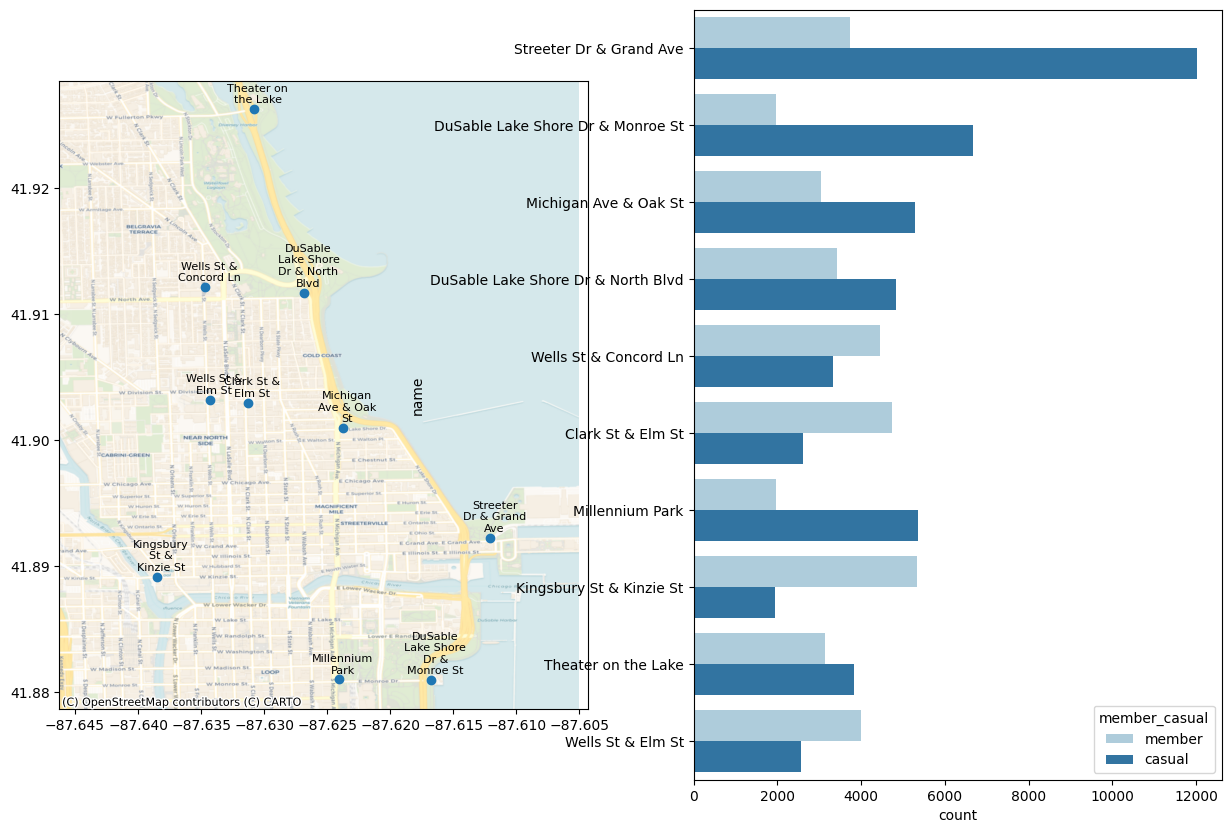

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
ax1 = gdf.plot(ax=axes[0])
cx.add_basemap(ax1, crs=gdf.crs.to_string(), source=cx.providers.CartoDB.Voyager)


for i, r in gdf.iterrows():
    wrapped_text = textwrap.fill(r['name'], width=10)
    ax1.annotate(wrapped_text, xy=(r.geometry.x, r.geometry.y), xytext=(3, 3), textcoords="offset points", fontsize=8, ha='center', va='bottom')

buffer_ratio = 0.1
x_range = ax.get_xlim()[1] - ax.get_xlim()[0]
ax1.set_xlim(ax.get_xlim()[0] - buffer_ratio * x_range, ax.get_xlim()[1] + buffer_ratio * x_range)


sns.countplot(ax=axes[1], data=plot_data, y='name', hue='member_casual', order=ab, palette='Paired')


plt.show()

# one map, one side by side bar plot

In [ ]:
chicago = gpd.read_file(gds.get_path('geoda.chicago_health'))
chicago.head(5)

In [30]:
chicago.crs

<Geographic 2D CRS: GEOGCS["WGS84(DD)",DATUM["WGS_1984",SPHEROID["WGS8 ...>
Name: WGS84(DD)
Axis Info [ellipsoidal]:
- lon[east]: Longitude (Degree)
- lat[north]: Latitude (Degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS84
- Prime Meridian: Greenwich

In [40]:
chicago.crs

<Geographic 2D CRS: GEOGCS["WGS84(DD)",DATUM["WGS_1984",SPHEROID["WGS8 ...>
Name: WGS84(DD)
Axis Info [ellipsoidal]:
- lon[east]: Longitude (Degree)
- lat[north]: Latitude (Degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS84
- Prime Meridian: Greenwich

In [ ]:
chicago.centroid.explore()

In [37]:
ax = chicago.centroid.explore()
cx.add_basemap(ax, crs=chicago.crs.to_string())

C:\Users\Andy\AppData\Local\Temp\ipykernel_22432\1963832225.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ax = chicago.centroid.explore()


AttributeError: 'Map' object has no attribute 'axis'

In [ ]:
station_list.drop(['electric_bike_surcharge_waiver', 'has_kiosk', 'rental_uris', 'eightd_has_key_dispenser', 'eightd_station_services', 'target_bike_capacity', 'target_scooter_capacity', 'region_id', 'region_code', 'client_station_id', 'rack_model'], axis=1, inplace=True)